<a href="https://colab.research.google.com/github/stefanogiagu/corsoinfn/blob/main/notebooks/Hands_on_2_CNN_su_Acceleratori_FPGA_sglatest_lslatest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Training e compressione/semplificazione di una CNN per la ricostruzione a bassissima latenza di muoni del rivelatore RPC dell'esperimento ATLAS 

*   training di un modello teacher CNN VGG-like
*   compressione tramite quantizzazione a 4bit
*   training di un modello student VGG semplificato + quantizzato a 4 bit
*   ottmizzazione delle prestazioni del modello student via teacher-student knoweldge distillation
*   conversione e sintesi del modello su FPGA con hls4ml + VivadoHLS
*   sintesi custom del modello student tramite implementazione diretta in VHDL con Vivado 


Referenze:<p>
[articolo riferimento](https://epjc.epj.org/articles/epjc/abs/2021/11/10052_2021_Article_9770/10052_2021_Article_9770.html) <p>
[Q-keras](https://github.com/google/qkeras) <p>
[hls4ml](https://fastmachinelearning.org/hls4ml/) <p>
[Vivado](https://www.xilinx.com/products/design-tools/vivado.html)

Dataset disponibile su google drive e accessibile da google colab:

https://drive.google.com/drive/folders/1mAvJEI9KWWNRLCq3d5VROHPVtei6SZkV?usp=sharing

aprire il file dal browser, aggiungere uno short cut al proprio google drive, e poi montare il google drive da google colab


```
from google.colab import drive
drive.mount('/content/drive')
```

Se si vogliono copiare i files sulla propria macchina locale (sono 4 files per un totaler di circa 6GB):

```
wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1-03Pr2BrRiGSRDSKLdQY2oHGFmX-s3w2' -O- | sed -rn 's/.*confirm=([1-9A-Za-z_]+).*/\1\n/p')&id=1-03Pr2BrRiGSRDSKLdQY2oHGFmX-s3w2" -O train_images384_1mu_with_bkg.npy && rm -rf /tmp/cookies.txt

wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1F-PJxd79yaIu0_uQqLJWlrHNryJmECak' -O- | sed -rn 's/.*confirm=([1-9A-Za-z_]+).*/\1\n/p')&id=1F-PJxd79yaIu0_uQqLJWlrHNryJmECak" -O train_full_labels384_1mu_with_bkg.npy && rm -rf /tmp/cookies.txt

wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1IEv2C06Gj9mDOQSuf0MoPZrSZUGzKf9M' -O- | sed -rn 's/.*confirm=([1-9A-Za-z_]+).*/\1\n/p')&id=1IEv2C06Gj9mDOQSuf0MoPZrSZUGzKf9M" -O test_images384_1mu_with_bkg.npy && rm -rf /tmp/cookies.txt

wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1_I0bOqI0NR2Gk6Kh9aMnl3wZQrDZLthu' -O- | sed -rn 's/.*confirm=([1-9A-Za-z_]+).*/\1\n/p')&id=1_I0bOqI0NR2Gk6Kh9aMnl3wZQrDZLthu" -O test_full_labels384_1mu_with_bkg.npy && rm -rf /tmp/cookies.txt
```



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# installazione librerie Q-keras per la quantizzazione di layer Tensofrlow/keras
!pip install qkeras

     |████████████████████████████████| 152 kB 5.4 MB/s 
     |████████████████████████████████| 237 kB 33.9 MB/s 
     |████████████████████████████████| 133 kB 46.5 MB/s 
  Created wheel for pyparser: filename=pyparser-1.0-py3-none-any.whl size=4943 sha256=0c38b5038c9615926948b0e3922711f0b9a8d95e03d26fb7be43c8031ed52c30
  Stored in directory: /root/.cache/pip/wheels/84/80/fe/49e0cb63aba370d3ef38e733a2266c90a4d837921664320003
  Created wheel for parse: filename=parse-1.6.5-py3-none-any.whl size=18176 sha256=6cbf7e72dbe0b7687b0e23c536f531bb7894c589e2310b7fbf9a6ee2b520888a
  Stored in directory: /root/.cache/pip/wheels/d3/d2/3e/3df86c4fd6ebac1348fbbda0a551e28cacf7301969935732dd
Successfully built pyparser parse


In [ ]:
# Librerie 
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import * 
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from qkeras import *
from qkeras.utils import model_save_quantized_weights
import os

In [ ]:
# Lettura del dataset
# utilizziamo solo le prime 100k immagini del training dataset e del test (per velocizzare il training)

n = int(10e4)
train_images = np.load('/content/drive/MyDrive/DATI_AI/train_images384_1mu_with_bkg.npy')[:n]
train_labels = np.load('/content/drive/MyDrive/DATI_AI/train_full_labels384_1mu_with_bkg.npy')[:n]

test_images = np.load('/content/drive/MyDrive/DATI_AI/test_images384_1mu_with_bkg.npy')[:n]
test_labels = np.load('/content/drive/MyDrive/DATI_AI/test_full_labels384_1mu_with_bkg.npy')[:n]

# siamo interessati solo alla colonna 0 (pt) e 1 (eta) dei vettori label
train_labels = train_labels[:, 0:2]
test_labels = test_labels[:, 0:2]

print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(100000, 9, 384)
(100000, 2)
(100000, 9, 384)
(100000, 2)


In [ ]:
# selezioniamo eventi con pt>4 GeV

selector_train = train_labels[:, 0]>4.0
selector_test = test_labels[:, 0]>4.0

train_images = train_images[selector_train]
train_labels = train_labels[selector_train]
test_images = test_images[selector_test]
test_labels = test_labels[selector_test]

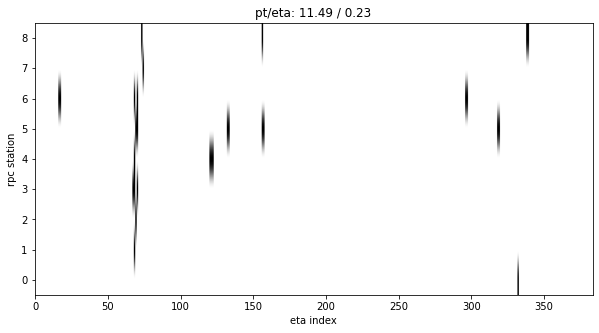

In [ ]:
# esempio immagine
idx=1
plt.figure(figsize=(10,5))
plt.imshow(train_images[idx], origin='lower', aspect='auto', cmap='binary')
plt.xlabel('eta index')
plt.ylabel('rpc station')
_ = plt.title('pt/eta: '+str(round(train_labels[idx,0],2))+" / "+str(round(train_labels[idx,1],2)))

In [ ]:
# normalizziamo i target in modo che siano entrambi compresi tra 0 e 1
# NOTA: in questo esempio specifico non è necessario normalizzare i vettori delle immagini ad avere valori in [0,1] o con media=0 e sdev=1, perché le immagini
# sono di tipo binario (i pixel hanno solo valori 0 o 1)
scaler = MinMaxScaler()

scaler.fit(train_labels)
train_labels = scaler.transform(train_labels)
test_labels = scaler.transform(test_labels)

# reshape delle immagini nel formato richiesto da keras
train_images = train_images.reshape((train_images.shape[0], 9, 384,1))
test_images = test_images.reshape((test_images.shape[0], 9, 384,1))

# conversione dei valori degli array a float32 come richiesto da keras
train_images = train_images.astype('float32')
train_labels = train_labels.astype('float32')
test_images = test_images.astype('float32')
test_labels = test_labels.astype('float32')

print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(47952, 9, 384, 1)
(47952, 2)
(90575, 9, 384, 1)
(90575, 2)


In [ ]:
# Modello Teacher: VGG full fledged con ~33k parametri trainabili
kernel = (3,3)
n_filter1 = 16
n_filter2 = 30
n_dense = 50


# modello funzionale
inputs = Input(train_images[0].shape, name = 'input')

# primo blocco convoluzionale (4 convoluzioni 2D con attivazione relu + average pooling finale 
# NOTA: usiamo padding='same' nelle convoluzioni e utilizziamo stariding + pooling per il downsampling dell'output
x = Conv2D(n_filter1, kernel, strides=(1,2), activation = 'relu', padding = 'same', name = 'Conv1a')(inputs) 
x = Conv2D(n_filter1, kernel, strides=(1,2), activation = 'relu', padding = 'same', name = 'Conv1b')(x) 
x = Conv2D(n_filter1, kernel, strides=(1,2), activation = 'relu', padding = 'same', name = 'Conv1c')(x) 
x = AveragePooling2D((1,2))(x)

# seconod blocco convoluzionale 
x = Conv2D(n_filter2, kernel, strides=(1,2), activation = 'relu', padding = 'same', name = 'Conv2a')(x) 
x = Conv2D(n_filter2, kernel, strides=(1,2), activation = 'relu', padding = 'same', name = 'Conv2b')(x) 
x = Conv2D(n_filter2, kernel, strides=(1,2), activation = 'relu', padding = 'same', name = 'Conv2c')(x)  
x = AveragePooling2D((3,3))(x)

# flatten layer per adattare l'uscita dell'ultima convoluzione al blocco fully connected usato per la task di regressione
x = Flatten()(x)

# fully connected block
x = Dense(n_dense, activation = 'relu', name = 'Dense1')(x)
x = Dense(n_dense, activation = 'relu', name = 'Dense2')(x)

# output lineare, dimensione 2 (pt, eta)
x = Dense(2, name = 'Output')(x)

# modello finale
teacher = keras.Model(inputs=[inputs], outputs=[x])
teacher.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 9, 384, 1)]       0         
                                                                 
 Conv1a (Conv2D)             (None, 9, 192, 16)        160       
                                                                 
 Conv1b (Conv2D)             (None, 9, 96, 16)         2320      
                                                                 
 Conv1c (Conv2D)             (None, 9, 48, 16)         2320      
                                                                 
 average_pooling2d (AverageP  (None, 9, 24, 16)        0         
 ooling2D)                                                       
                                                                 
 Conv2a (Conv2D)             (None, 9, 12, 30)         4350      
                                                             

In [ ]:
# Compilazione e training del modello teacher

teacher.compile(optimizer='adam',loss='mse' ,metrics=['mse','mae'])

# early stopping e model checkpoints
callbacks = [keras.callbacks.EarlyStopping(monitor='val_mse', patience=5, min_delta = 0.00001, restore_best_weights=False), 
             keras.callbacks.ModelCheckpoint(filepath='teacher_best', monitor='val_mse', verbose=1, save_best_only=True, save_freq='epoch'),]

history = teacher.fit(train_images, train_labels, epochs=50, batch_size=100, validation_split=0.2, callbacks=callbacks)

Epoch 1/50
384/384 [==============================] - ETA: 0s - loss: 0.0547 - mse: 0.0547 - mae: 0.1772
Epoch 1: val_mse improved from inf to 0.02323, saving model to teacher_best
INFO:tensorflow:Assets written to: teacher_best/assets
384/384 [==============================] - 26s 34ms/step - loss: 0.0547 - mse: 0.0547 - mae: 0.1772 - val_loss: 0.0232 - val_mse: 0.0232 - val_mae: 0.1052
Epoch 2/50
374/384 [============================>.] - ETA: 0s - loss: 0.0194 - mse: 0.0194 - mae: 0.0926

KeyboardInterrupt: ignored

In [ ]:
# plot loss e mae vs epoca di training

plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()

plt.plot(history.history['mae'], label = 'mae')
plt.plot(history.history['val_mae'], label = 'val_mae')
plt.legend()
plt.show()

In [ ]:
# carica il best model
teacher = keras.models.load_model('teacher_best')

predictions = scaler.inverse_transform(teacher.predict(test_images))

#MakePlots(predictions, test_images, test_labels, path, history)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


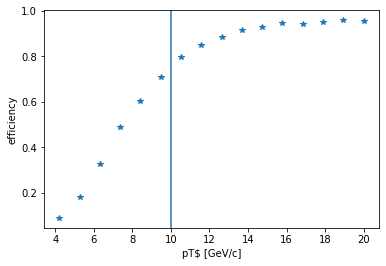

In [ ]:
# Turnon curva di efficienza del trigger in funzione del pt

# modo facile per ottenerlo: creare due histogrammi uno con la distribuzione di pt per gli eventi che passono il taglio 
# pt_predetto > soglia e uno con la distribuzione di tutti gli eventi e poi fare il rapporto tra i due istogrammi

predictions = predictions[:,0]
pttrue = scaler.inverse_transform(test_labels)[:,0]
soglia = 10.0 #soglia nominale di trigger Pt>10 GeV/c
numer,_ = np.histogram(pttrue[predictions>soglia], bins=20, range=(0.,20.))
denum,_ = np.histogram(pttrue, bins=20, range=(0.,20.))

eff = numer/denum
lrvalues = np.linspace(0.,20.,20)

_ = plt.plot(lrvalues,eff, '*')
_ = plt.axvline(x=soglia)
_ = plt.xlabel("pT$ [GeV/c]")
_ = plt.ylabel("efficiency")

In [ ]:
# Modello Student: Simile al Teacher ma con molti meno parametri (~1k parametri trainabili)
kernel = (3,3)
n_dense = 10

inputs = Input(train_images[0].shape, name = 'input')

x = Conv2D(1, kernel, strides=(1,2), activation = 'relu', padding = 'same', name = 'Student_Conv1a')(inputs) 
x = Conv2D(2, kernel, strides=(1,2), activation = 'relu', padding = 'same', name = 'Student_Conv1b')(x) 
x = Conv2D(2, kernel, strides=(1,2), activation = 'relu', padding = 'same', name = 'Student_Conv1c')(x) 
x = AveragePooling2D((1,2))(x)

x = Conv2D(8, kernel, strides=(1,2), activation = 'relu', padding = 'same', name = 'Student_Conv2a')(x) 
x = Conv2D(4, kernel, strides=(1,2), activation = 'relu', padding = 'same', name = 'Student_Conv2b')(x) 
x = Conv2D(8, kernel, strides=(1,2), activation = 'relu', padding = 'same', name = 'Student_Conv2c')(x) 
x = AveragePooling2D((3,3))(x)

x = Flatten()(x) 
x = Dense(n_dense, activation = 'relu', name = 'Student_Dense1')(x)
x = Dense(n_dense, activation = 'relu', name = 'Student_Dense2')(x)

x = Dense(2, name = 'Student_Output')(x)

# modello finale
student = keras.Model(inputs=[inputs], outputs=[x])
student.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 9, 384, 1)]       0         
                                                                 
 Student_Conv1a (Conv2D)     (None, 9, 192, 1)         10        
                                                                 
 Student_Conv1b (Conv2D)     (None, 9, 96, 2)          20        
                                                                 
 Student_Conv1c (Conv2D)     (None, 9, 48, 2)          38        
                                                                 
 average_pooling2d_2 (Averag  (None, 9, 24, 2)         0         
 ePooling2D)                                                     
                                                                 
 Student_Conv2a (Conv2D)     (None, 9, 12, 8)          152       
                                                           

In [ ]:
# Compilazione e training del modello student

student.compile(optimizer='adam',loss='mse' ,metrics=['mse'])

# early stopping e model checkpoints
callbacks = [keras.callbacks.EarlyStopping(monitor='val_mse', patience=5, min_delta = 0.00001, restore_best_weights=False), 
             keras.callbacks.ModelCheckpoint(filepath='student_best', monitor='val_mse', verbose=1, save_best_only=True, save_freq='epoch'),]

history = student.fit(train_images, train_labels, epochs=50, batch_size=100, validation_split=0.2, callbacks=callbacks)

Epoch 1/50
384/384 [==============================] - ETA: 0s - loss: 0.0994 - mse: 0.0994
Epoch 1: val_mse improved from inf to 0.07675, saving model to student_best
INFO:tensorflow:Assets written to: student_best/assets
384/384 [==============================] - 7s 17ms/step - loss: 0.0994 - mse: 0.0994 - val_loss: 0.0767 - val_mse: 0.0767
Epoch 2/50
266/384 [===================>..........] - ETA: 1s - loss: 0.0758 - mse: 0.0758

KeyboardInterrupt: ignored

In [ ]:
# carica il best model
student = keras.models.load_model('student_best')

predictions_s = scaler.inverse_transform(student.predict(test_images))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


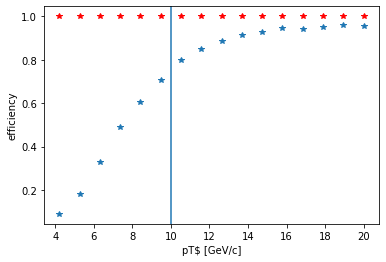

In [ ]:
# Turnon curva di efficienza del trigger in funzione del pt

# modo facile per ottenerlo: creare due histogrammi uno con la distribuzione di pt per gli eventi che passono il taglio 
# pt_predetto > soglia e uno con la distribuzione di tutti gli eventi e poi fare il rapporto tra i due istogrammi

predictions_s = predictions_s[:,0]
pttrue = scaler.inverse_transform(test_labels)[:,0]
soglia = 10.0 #soglia nominale di trigger Pt>10 GeV/c
numer_s,_ = np.histogram(pttrue[predictions_s>soglia], bins=20, range=(0.,20.))
denum_s,_ = np.histogram(pttrue, bins=20, range=(0.,20.))

eff_s = numer_s/denum_s
lrvalues = np.linspace(0.,20.,20)

_ = plt.plot(lrvalues,eff, '*')
_ = plt.plot(lrvalues,eff_s, 'r*')
_ = plt.axvline(x=soglia)
_ = plt.xlabel("pT$ [GeV/c]")
_ = plt.ylabel("efficiency")

NOTA: lo student f32 anche se con soli 1k parametri non può essere implementato su una FPGA Xilinx UltraScale+ xcvu13p anche se è una delle più grandi e costose disponibili oggi ...

È necessario quantizzare in modo spinto il modello.

In [ ]:
# Studente quantizzato fixed-point a 4 bit con libreria Qkeras
# l'output layer non viene quantizzato

kernel = (3,3)
n_dense = 10

sym = 1
myalpha = None
nbits = 4

inputs = Input(train_images[0].shape, name = 'input')

x = QConv2D(1, kernel, strides=(1,2), kernel_quantizer = quantized_bits(nbits,0,sym,alpha=myalpha), 
            bias_quantizer = quantized_bits(nbits,0,1,alpha=myalpha), padding = 'same', name = 'Qstudent_Conv1a')(inputs) 
x = QActivation('quantized_relu('+str(nbits)+')')(x) 
x = QConv2D(2, kernel, strides=(1,2), kernel_quantizer = quantized_bits(nbits,0,sym,alpha=myalpha), 
            bias_quantizer = quantized_bits(nbits,0,1,alpha=myalpha), padding = 'same', name = 'Qstudent_Conv1b')(x) 
x = QActivation('quantized_relu('+str(nbits)+')')(x)
x = QConv2D(2, kernel, strides=(1,2), kernel_quantizer = quantized_bits(nbits,0,sym,alpha=myalpha), 
            bias_quantizer = quantized_bits(nbits,0,1,alpha=myalpha), padding = 'same', name = 'Qstudent_Conv1c')(x) 
x = QActivation('quantized_relu('+str(nbits)+')')(x)
x = QAveragePooling2D(pool_size=(1,2), activation='quantized_relu('+str(nbits)+')')(x)

x = QConv2D(8, kernel, strides=(1,2), kernel_quantizer = quantized_bits(nbits,0,sym,alpha=myalpha),
            bias_quantizer = quantized_bits(nbits,0,1,alpha=myalpha), padding = 'same', name = 'Qstudent_Conv2a')(x) 
x = QActivation('quantized_relu('+str(nbits)+')')(x) 
x = QConv2D(4, kernel, strides=(1,2), kernel_quantizer = quantized_bits(nbits,0,sym,alpha=myalpha),
            bias_quantizer = quantized_bits(nbits,0,1,alpha=myalpha), padding = 'same', name = 'Qstudent_Conv2b')(x)
x = QActivation('quantized_relu('+str(nbits)+')')(x) 
x = QConv2D(8, kernel, strides=(1,2), kernel_quantizer = quantized_bits(nbits,0,sym,alpha=myalpha),
            bias_quantizer = quantized_bits(nbits,0,1,alpha=myalpha), padding = 'same', name = 'Qstudent_Conv2c')(x) 
x = QActivation('quantized_relu('+str(nbits)+')')(x) 
x = QAveragePooling2D(pool_size=(3,3), activation='quantized_relu('+str(nbits)+')')(x)

x = Flatten()(x) 
x = QDense(n_dense, kernel_quantizer = quantized_bits(nbits,0,sym,alpha=myalpha),
           bias_quantizer = quantized_bits(nbits,0,1,alpha=myalpha), name = 'Qstudent_Dense1')(x)
x = QActivation('quantized_relu('+str(nbits)+')')(x) 
x = QDense(n_dense, kernel_quantizer = quantized_bits(nbits,0,sym,alpha=myalpha),
           bias_quantizer = quantized_bits(nbits,0,1,alpha=myalpha), name = 'Qstudent_Dense2')(x)
x = QActivation('quantized_relu('+str(nbits)+')')(x) 
    
x = Dense(2, name = 'Output')(x)

qstudent = keras.Model(inputs=[inputs], outputs=[x])
qstudent.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 9, 384, 1)]       0         
                                                                 
 Qstudent_Conv1a (QConv2D)   (None, 9, 192, 1)         10        
                                                                 
 q_activation (QActivation)  (None, 9, 192, 1)         0         
                                                                 
 Qstudent_Conv1b (QConv2D)   (None, 9, 96, 2)          20        
                                                                 
 q_activation_1 (QActivation  (None, 9, 96, 2)         0         
 )                                                               
                                                                 
 Qstudent_Conv1c (QConv2D)   (None, 9, 48, 2)          38        
                                                           

In [ ]:
# Compilazione e training del modello Qstudent

qstudent.compile(optimizer='adam',loss='mse' ,metrics=['mse'])

# early stopping e model checkpoints
callbacks = [keras.callbacks.EarlyStopping(monitor='val_mse', patience=5, min_delta = 0.00001, restore_best_weights=False), 
             keras.callbacks.ModelCheckpoint(filepath='qstudent_best', monitor='val_mse', verbose=1, save_best_only=True, save_freq='epoch'),]

history = qstudent.fit(train_images, train_labels, epochs=50, batch_size=128, validation_split=0.2, callbacks=callbacks)

Epoch 1/50
300/300 [==============================] - ETA: 0s - loss: 0.1138 - mse: 0.1138
Epoch 1: val_mse improved from inf to 0.07985, saving model to qstudent_best
INFO:tensorflow:Assets written to: qstudent_best/assets
300/300 [==============================] - 33s 83ms/step - loss: 0.1138 - mse: 0.1138 - val_loss: 0.0799 - val_mse: 0.0799
Epoch 2/50
299/300 [============================>.] - ETA: 0s - loss: 0.0747 - mse: 0.0747
Epoch 2: val_mse improved from 0.07985 to 0.06423, saving model to qstudent_best


KeyboardInterrupt: ignored

In [ ]:
# carica il best model
qstudent = keras.models.load_model('qstudent_best')

predictions_qs = scaler.inverse_transform(qstudent.predict(test_images))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


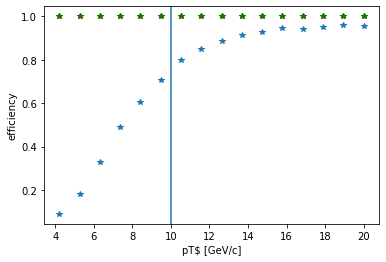

In [ ]:
# Turnon curva di efficienza del trigger in funzione del pt

# modo facile per ottenerlo: creare due histogrammi uno con la distribuzione di pt per gli eventi che passono il taglio 
# pt_predetto > soglia e uno con la distribuzione di tutti gli eventi e poi fare il rapporto tra i due istogrammi

predictions_qs = predictions_qs[:,0]
pttrue = scaler.inverse_transform(test_labels)[:,0]
soglia = 10.0 #soglia nominale di trigger Pt>10 GeV/c
numer_qs,_ = np.histogram(pttrue[predictions_qs>soglia], bins=20, range=(0.,20.))
denum_qs,_ = np.histogram(pttrue, bins=20, range=(0.,20.))

eff_qs = numer_qs/denum_qs
lrvalues = np.linspace(0.,20.,20)

_ = plt.plot(lrvalues,eff, '*')
_ = plt.plot(lrvalues,eff_s, 'r*')
_ = plt.plot(lrvalues,eff_qs, 'g*')
_ = plt.axvline(x=soglia)
_ = plt.xlabel("pT$ [GeV/c]")
_ = plt.ylabel("efficiency")

In [ ]:
# Studente (float) adestrato con knoweldge distillation


# Classe custom Layer per la HintLoss
class HintLossLayer(tf.keras.layers.Layer):
    def __init__(self, gamma=0.2, name = "name", mname = "hint"):
        super(HintLossLayer, self).__init__(name = name)
        self.gamma = gamma
        self.mname = mname
    def call(self, inputs):
        self.add_loss(tf.reduce_mean(tf.square(inputs[1]- inputs[2])) * self.gamma)
        self.add_metric(tf.reduce_mean((tf.square(inputs[1]- inputs[2]))) * self.gamma, name = self.mname, aggregation="mean")
        return inputs[0]
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'gamma': self.gamma
        })
        return config


# Classe custom Model per la distillazione 
act = "relu"
d = 0.2
class CustomModel(keras.Model):
    def train_step(self, data):
        
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.
        x, y = data   

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass

            stud = tf.reduce_mean(tf.square(y_pred[0]-y))
            teach = tf.reduce_mean(tf.square(y_pred[1]-y))
            f0 = lambda: tf.constant(0.)
            f1 = lambda: tf.constant(1.)
            w = tf.case([(tf.less(teach, stud), f1)], default=f0)
            loss = self.compiled_loss(y, y_pred[0], regularization_losses= [w*l for l in self.losses])

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(y, y_pred)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}

In [ ]:
# Modello Student distillato: Student di prima con adaptation layers

dictionary = {'33k': {'pad1_tuple': (0,12), 'block1': 'Conv1c', 'conv2_filter': 30, 'block2': 'Conv2c', 
                      'pad2_tuple': (3,1), 'dense': 50}}
teach_name = '33k'
key = list(dictionary[teach_name].keys())
print(key)

key = list(dictionary[teach_name].keys())
pad1_tuple = dictionary[teach_name][key[0]]
block1 = dictionary[teach_name][key[1]]
conv2_filter = dictionary[teach_name][key[2]]
block2 = dictionary[teach_name][key[3]]
pad2_tuple = dictionary[teach_name][key[4]]
dense = dictionary[teach_name][key[5]]

nbits = 4
avebits = 4

kernel = (3,3)
n_dense = 10
sym = 1
myalpha = None

gamma1=1.0
gamma2=0.01
gamma3=0.1

teacher = keras.models.load_model('teacher_best')
for i in range(len(teacher.layers)):
    teacher.layers[i].trainable = False
    if "Dropout" in teacher.layers[i].name:
        teacher.layers[i].rate = 0
        print(teacher.layers[i].rate)


inputs = Input(train_images[0].shape, name = 'Student_input')

x = QConv2D(1, kernel, strides=(1,2), kernel_quantizer = quantized_bits(nbits,0,sym,alpha=myalpha), 
            bias_quantizer = quantized_bits(nbits,0,1,alpha=myalpha), padding = 'same', name = 'Student_Conv1a')(inputs) 
x = QActivation('quantized_relu('+str(nbits)+')')(x) 
x = QConv2D(2, kernel, strides=(1,2), kernel_quantizer = quantized_bits(nbits,0,sym,alpha=myalpha), 
            bias_quantizer = quantized_bits(nbits,0,1,alpha=myalpha), padding = 'same', name = 'Student_Conv1b')(x) 
x = QActivation('quantized_relu('+str(nbits)+')')(x)
x = QConv2D(2, kernel, strides=(1,2), kernel_quantizer = quantized_bits(nbits,0,sym,alpha=myalpha), 
            bias_quantizer = quantized_bits(nbits,0,1,alpha=myalpha), padding = 'same', name = 'Student_Conv1c')(x) 
x = QActivation('quantized_relu('+str(nbits)+')')(x)
x = QAveragePooling2D(pool_size=(1,2), activation='quantized_relu('+str(avebits)+')')(x)
padding1 = tf.keras.layers.ZeroPadding2D(pad1_tuple)(x)
Adap1 = Conv2D(1, (1,1), activation = 'relu', padding = 'same', name = 'Student_Adap1')(padding1)
hint1 = HintLossLayer(gamma = gamma1, name = 'Hint1', mname = 'Hint1')([x, Adap1, teacher.get_layer(block1).output])

x = QConv2D(8, kernel, strides=(1,2), kernel_quantizer = quantized_bits(nbits,0,sym,alpha=myalpha),
            bias_quantizer = quantized_bits(nbits,0,1,alpha=myalpha), padding = 'same', name = 'Student_Conv2a')(hint1) 
x = QActivation('quantized_relu('+str(nbits)+')')(x) 
x = QConv2D(4, kernel, strides=(1,2), kernel_quantizer = quantized_bits(nbits,0,sym,alpha=myalpha),
            bias_quantizer = quantized_bits(nbits,0,1,alpha=myalpha), padding = 'same', name = 'Student_Conv2b')(x)
x = QActivation('quantized_relu('+str(nbits)+')')(x) 
x = QConv2D(8, kernel, strides=(1,2), kernel_quantizer = quantized_bits(nbits,0,sym,alpha=myalpha),
            bias_quantizer = quantized_bits(nbits,0,1,alpha=myalpha), padding = 'same', name = 'Student_Conv2c')(x) 
x = QActivation('quantized_relu('+str(nbits)+')')(x) 
x = QAveragePooling2D(pool_size=(3,3), activation='quantized_relu('+str(avebits)+')')(x)
padding2 = tf.keras.layers.ZeroPadding2D(pad2_tuple)(x)
Adap2 = Conv2D(conv2_filter, (1,1), activation = 'relu', padding = 'same', name = 'Student_Adap2')(padding2)
hint2 = HintLossLayer(gamma = gamma2, name = 'Hint2', mname = 'Hint2')([x, Adap2, teacher.get_layer(block2).output])

x = Flatten()(hint2)
x = QDense(n_dense, kernel_quantizer = quantized_bits(nbits,0,sym,alpha=myalpha),
           bias_quantizer = quantized_bits(nbits,0,1,alpha=myalpha), name = 'Student_Dense1')(x)
x = QActivation('quantized_relu('+str(nbits)+')')(x) 
x = QDense(n_dense, kernel_quantizer = quantized_bits(nbits,0,sym,alpha=myalpha),
           bias_quantizer = quantized_bits(nbits,0,1,alpha=myalpha), name = 'Student_Dense2')(x)
x = QActivation('quantized_relu('+str(nbits)+')')(x)
Adap3 = Dense(dense, activation = 'relu', name = 'Student_Adap3')(x)
hint3 = HintLossLayer(gamma = gamma3, name = 'Hint3', mname = 'Hint3')([x, Adap3, teacher.get_layer('Dense2').output])

x = Dense(2, name = 'Student_Output')(hint3) 

# modello finale
qstudent_dist = CustomModel(inputs=[inputs, teacher.layers[0].input], outputs=[x, teacher.layers[-1].output])
qstudent_dist.summary()

['pad1_tuple', 'block1', 'conv2_filter', 'block2', 'pad2_tuple', 'dense']
Model: "custom_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Student_input (InputLayer)     [(None, 9, 384, 1)]  0           []                               
                                                                                                  
 Student_Conv1a (QConv2D)       (None, 9, 192, 1)    10          ['Student_input[0][0]']          
                                                                                                  
 q_activation_8 (QActivation)   (None, 9, 192, 1)    0           ['Student_Conv1a[0][0]']         
                                                                                                  
 Student_Conv1b (QConv2D)       (None, 9, 96, 2)     20          ['q_activation_8[0][0]']         
             

In [ ]:
# compilazione e training
import gc
class GarbageCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()

qstudent_dist.compile(optimizer='adam',loss='mse' ,metrics=['mse'])

# early stopping e model checkpoints
callbacks = [keras.callbacks.EarlyStopping(monitor='val_Student_Output_mse', patience=5, min_delta = 0.00001, restore_best_weights=False), 
             keras.callbacks.ModelCheckpoint(filepath='qstudent_dist_best', monitor='val_Student_Output_mse', verbose=1, save_best_only=True, save_freq='epoch'),
             GarbageCallback()]

history = qstudent_dist.fit([train_images, train_images], [train_labels,train_labels], epochs=50, batch_size=128, validation_split=0.2, callbacks=callbacks)



Epoch 1/50
300/300 [==============================] - ETA: 0s - loss: 0.2333 - Student_Output_loss: 0.2287 - Student_Output_mse: 0.2287 - Output_mse: 0.0236 - Hint1: 0.0017 - Hint2: 3.0953e-04 - Hint3: 0.0026
Epoch 1: val_Student_Output_mse improved from inf to 0.14536, saving model to qstudent_dist_best


INFO:tensorflow:Assets written to: qstudent_dist_best/assets


INFO:tensorflow:Assets written to: qstudent_dist_best/assets


300/300 [==============================] - 38s 101ms/step - loss: 0.2333 - Student_Output_loss: 0.2287 - Student_Output_mse: 0.2287 - Output_mse: 0.0236 - Hint1: 0.0017 - Hint2: 3.0953e-04 - Hint3: 0.0026 - val_loss: 0.1490 - val_Student_Output_loss: 0.1454 - val_Student_Output_mse: 0.1454 - val_Output_mse: 0.0232 - val_Hint1: 0.0017 - val_Hint2: 2.7468e-04 - val_Hint3: 0.0017
Epoch 2/50
299/300 [============================>.] - ETA: 0s - loss: 0.1126 - Student_Output_loss: 0.1092 - Student_Output_mse: 0.1092 - Output_mse: 0.0236 - Hint1: 0.0017 - Hint2: 2.6938e-04 - Hint3: 0.0014
Epoch 2: val_Student_Output_mse improved from 0.14536 to 0.08743, saving model to qstudent_dist_best


INFO:tensorflow:Assets written to: qstudent_dist_best/assets


INFO:tensorflow:Assets written to: qstudent_dist_best/assets


300/300 [==============================] - 27s 90ms/step - loss: 0.1126 - Student_Output_loss: 0.1092 - Student_Output_mse: 0.1092 - Output_mse: 0.0236 - Hint1: 0.0017 - Hint2: 2.6945e-04 - Hint3: 0.0014 - val_loss: 0.0907 - val_Student_Output_loss: 0.0874 - val_Student_Output_mse: 0.0874 - val_Output_mse: 0.0232 - val_Hint1: 0.0017 - val_Hint2: 2.7153e-04 - val_Hint3: 0.0013
Epoch 3/50
300/300 [==============================] - ETA: 0s - loss: 0.0844 - Student_Output_loss: 0.0812 - Student_Output_mse: 0.0812 - Output_mse: 0.0236 - Hint1: 0.0017 - Hint2: 2.6874e-04 - Hint3: 0.0012
Epoch 3: val_Student_Output_mse improved from 0.08743 to 0.07770, saving model to qstudent_dist_best


INFO:tensorflow:Assets written to: qstudent_dist_best/assets


INFO:tensorflow:Assets written to: qstudent_dist_best/assets


300/300 [==============================] - 27s 90ms/step - loss: 0.0844 - Student_Output_loss: 0.0812 - Student_Output_mse: 0.0812 - Output_mse: 0.0236 - Hint1: 0.0017 - Hint2: 2.6874e-04 - Hint3: 0.0012 - val_loss: 0.0809 - val_Student_Output_loss: 0.0777 - val_Student_Output_mse: 0.0777 - val_Output_mse: 0.0232 - val_Hint1: 0.0017 - val_Hint2: 2.7152e-04 - val_Hint3: 0.0012
Epoch 4/50
299/300 [============================>.] - ETA: 0s - loss: 0.0807 - Student_Output_loss: 0.0775 - Student_Output_mse: 0.0775 - Output_mse: 0.0236 - Hint1: 0.0017 - Hint2: 2.6872e-04 - Hint3: 0.0012
Epoch 4: val_Student_Output_mse improved from 0.07770 to 0.07683, saving model to qstudent_dist_best


INFO:tensorflow:Assets written to: qstudent_dist_best/assets


INFO:tensorflow:Assets written to: qstudent_dist_best/assets


300/300 [==============================] - 28s 94ms/step - loss: 0.0806 - Student_Output_loss: 0.0775 - Student_Output_mse: 0.0775 - Output_mse: 0.0236 - Hint1: 0.0017 - Hint2: 2.6877e-04 - Hint3: 0.0012 - val_loss: 0.0800 - val_Student_Output_loss: 0.0768 - val_Student_Output_mse: 0.0768 - val_Output_mse: 0.0232 - val_Hint1: 0.0017 - val_Hint2: 2.7150e-04 - val_Hint3: 0.0012
Epoch 5/50
252/300 [========================>.....] - ETA: 1s - loss: 0.0804 - Student_Output_loss: 0.0772 - Student_Output_mse: 0.0772 - Output_mse: 0.0235 - Hint1: 0.0017 - Hint2: 2.6911e-04 - Hint3: 0.0012

KeyboardInterrupt: ignored

In [ ]:
# carica il best model
qstudent_dist = keras.models.load_model('qstudent_dist_best')

#qstudent_dist = keras.models.load_model('net.tf')
#qstudent_dist.summary()

predictions_qs_dist = qstudent_dist.predict([test_images, test_images])[0]
predictions_qs_dist = np.array(predictions_qs_dist)
predictions_qs_dist = scaler.inverse_transform(predictions_qs_dist)

In [ ]:
# Turnon curva di efficienza del trigger in funzione del pt

# modo facile per ottenerlo: creare due histogrammi uno con la distribuzione di pt per gli eventi che passono il taglio 
# pt_predetto > soglia e uno con la distribuzione di tutti gli eventi e poi fare il rapporto tra i due istogrammi

predictions_qs_dist = predictions_qs_dist[:,0]
pttrue = scaler.inverse_transform(test_labels)[:,0]
soglia = 10.0 #soglia nominale di trigger Pt>10 GeV/c
numer_qs_d,_ = np.histogram(pttrue[predictions_qs_dist>soglia], bins=20, range=(0.,20.))
denum_qs_d,_ = np.histogram(pttrue, bins=20, range=(0.,20.))

eff_qs_d = numer_qs_d/denum_qs_d
lrvalues = np.linspace(0.,20.,20)

_ = plt.plot(lrvalues,eff, '*')
_ = plt.plot(lrvalues,eff_s, 'r*')
_ = plt.plot(lrvalues,eff_qs, 'g*')
_ = plt.plot(lrvalues,eff_qs_d, 'y*')
_ = plt.axvline(x=soglia)
_ = plt.xlabel("pT$ [GeV/c]")
_ = plt.ylabel("efficiency")

#1) Installazione HLS4ML + Vivado 
Per HLS4ML è sufficiente:

`pip install hls4ml`

(Al [link](https://fastmachinelearning.org/hls4ml/setup.html) la lista di ulteriori dependencies ed istruzioni aggiuntive)

HLS4ML è testato su Linux, e supporta le versioni di Vivado HLS da 2018.2 a 2020.1. Vitis HLS non è ancora supportato. Windows e macOS non sono supportati.

Per il download e l'installazione di Vivado si rimanda al [link](https://www.xilinx.com/support/download.html)

#Codice per traduzione del modello in VHDL via HLS4ML

In [ ]:
#2) poche di righe per far vedere come si sintetizza il modello 
#NOTA: che con immagini cosi grandi non funziona 
#RISULTATI: con immagini 16x9

In [ ]:
import hls4ml
filename = "Qstudent_"+str(nbits)+"_9x16"
model = load_model("net_student_4_9x16.tf")
nbits = 4
sym = 1
'''
model = Sequential()                                                                                                                                                              
model.add(Input((9,16,1), name = 'input_student'))                                                                                                                                
                                                                                                                                                                                  
model.add(QConv2D(1, (3,3), kernel_quantizer = quantized_bits(nbits,0,alpha = sym), bias_quantizer = quantized_bits(nbits,0,alpha = 1),  name = 'Student_Conv1a', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))                                                                                                                              
model.add( QActivation('quantized_relu('+str(nbits)+')'))
model.add(QConv2D(1, (3,3), kernel_quantizer = quantized_bits(nbits,0,alpha = sym), bias_quantizer = quantized_bits(nbits,0,alpha = 1),  name = 'Student_Conv1b', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))                                                                                                                              
model.add( QActivation('quantized_relu('+str(nbits)+')'))
model.add(QConv2D(6, (3,3), kernel_quantizer = quantized_bits(nbits,0,alpha = sym), bias_quantizer = quantized_bits(nbits,0,1),  name = 'Student_Conv2a'))
model.add(QActivation('quantized_relu('+str(nbits)+')'))
model.add(QConv2D(6, (3,3), kernel_quantizer = quantized_bits(nbits,0, alpha = sym), bias_quantizer = quantized_bits(nbits,0,1),  name = 'Student_Conv2b'))
model.add(QActivation('quantized_relu('+str(nbits)+')'))
model.add(Flatten())
model.add(QDense(10, name='fc1',
                 kernel_quantizer=quantized_bits(nbits,0,alpha=1), bias_quantizer=quantized_bits(nbits,0,alpha=1),
                 kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(QActivation(activation=quantized_relu(nbits), name='relu1'))
model.add(QDense(10, name='fc2',
                 kernel_quantizer=quantized_bits(nbits,0,alpha=1), bias_quantizer=quantized_bits(nbits,0,alpha=1),
                 kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(QActivation(activation=quantized_relu(nbits), name='relu2'))
model.add(Dense(2, name='output'))
'''          
model.summary()
model.compile(optimizer="adam", loss=['categorical_crossentropy'], metrics=['accuracy'])
config = hls4ml.utils.config_from_keras_model(model, granularity='name')

print("-----------------------------------")
plotting.print_dict(config)
print("-----------------------------------")

output_dir = filename + '/hls4ml_prj'
hls_model = hls4ml.converters.convert_from_keras_model(model,
                                                       hls_config=config,
                                                       output_dir=output_dir,
                                                       fpga_part='xcvu13p-flga2577-1-e',
                                                       io_type='io_stream', #o io_parallel, l'unico supportato (al momento?) per CNN è io_stream
                                                       clock_period= 2.5)
hls4ml.utils.fetch_example_list()

#Use Vivado HLS to synthesize the model                                                                                                                                           
#This might take several minutes                                                                                                                                                                                                                                                                                                              
hls_model.build(reset=False, csim=True, synth=True, cosim=True, validation=True, export=True, vsynth=True)

#Print out the report if you want                                                                                                                                                 
hls4ml.report.read_vivado_report(output_dir)

#Come evitare il problema e allo stesso tempo raggiungere latenze di O(100 ns)
- 16x9 -> 30 clock-cycles (94 ns @320MHz ) [177 clock-cycles = ~440ns @400MHz hls4ml]
- 384x9 -> 210 ns 


Estrazione pesi

In [ ]:
gl_in = [1, 3, 5,  15, 17, 19,  30, 33, 40]
gl_out = [1, 3, 5,  8, 10, 12,  16, 18, -1]
w_names = ["w_conv1a.npy", "w_conv1b.npy", "w_conv1c.npy", "avgpool", "w_conv2a.npy","w_conv2b.npy","w_conv2c.npy", "avgpool","w_dense1.npy", "w_dense2.npy", "w_out.npy" ]
b_names = ["b_conv1a.npy", "b_conv1b.npy", "b_conv1c.npy", "avgpool", "b_conv2a.npy","b_conv2b.npy","b_conv2c.npy", "avgpool", "b_dense1.npy", "b_dense2.npy", "b_out.npy" ]
model_trained = load_model("qstudent_dist_best")


weights = {}
nbits = 4
sym = 1
#model_trained.summary()
MyAlpha = None

in_layer = Input((9,384,1), name = 'input_student')

x = QConv2D(1, (3,3), strides = (1,2),  padding = "same", kernel_quantizer = quantized_bits(nbits,0, symmetric = 1, alpha = MyAlpha),
                  bias_quantizer = quantized_bits(nbits,0, symmetric = 1, alpha = None),  name = 'Student_Conv1a')(in_layer)
x = QActivation('quantized_relu('+str(nbits)+')')(x)
x = QConv2D(2, (3,3), strides = (1,2), padding = "same", kernel_quantizer = quantized_bits(nbits,0, symmetric = 1, alpha = MyAlpha),
                  bias_quantizer = quantized_bits(nbits,0, symmetric = 1, alpha = None),  name = 'Student_Conv1b')(x)
x = QActivation('quantized_relu('+str(nbits)+')')(x)
x = QConv2D(2, (3,3), strides = (1,2), padding = "same", kernel_quantizer = quantized_bits(nbits,0, symmetric = 1, alpha = MyAlpha),
                  bias_quantizer = quantized_bits(nbits,0, symmetric = 1, alpha = None),  name = 'Student_Conv1c')(x)
x = QActivation('quantized_relu('+str(nbits)+')')(x)
x = QAveragePooling2D((1,2), name = "ap1")(x)
x = QConv2D(8, (3,3), strides = (1,2), padding = "same", kernel_quantizer = quantized_bits(nbits,0, symmetric = 1, alpha = MyAlpha),
                  bias_quantizer = quantized_bits(nbits,0, symmetric = 1, alpha = None),  name = 'Student_Conv2a')(x)
x = QActivation('quantized_relu('+str(nbits)+')')(x)
x = QConv2D(4, (3,3), strides = (1,2), padding = "same", kernel_quantizer = quantized_bits(nbits,0, symmetric = 1, alpha = MyAlpha),
                  bias_quantizer = quantized_bits(nbits,0, symmetric = 1, alpha = None),  name = 'Student_Conv2b')(x)
x = QActivation('quantized_relu('+str(nbits)+')')(x)
x = QConv2D(8, (3,3), strides = (1,2), padding = "same", kernel_quantizer = quantized_bits(nbits,0, symmetric = 1, alpha = MyAlpha),
                  bias_quantizer = quantized_bits(nbits,0, symmetric = 1, alpha = None),  name = 'Student_Conv2c')(x)
x = QActivation('quantized_relu('+str(nbits)+')')(x)
x = QAveragePooling2D((3,3), name = "ap2")(x)

x = Flatten()(x)

x = QDense(10, name='fc1',
                 kernel_quantizer=quantized_bits(nbits,0, symmetric = 1, alpha = MyAlpha), bias_quantizer=quantized_bits(nbits,0, symmetric = 1, alpha = None ),
                )(x)

x = QActivation(activation=quantized_relu(nbits))(x)
x = QDense(10, name='fc2',
                 kernel_quantizer=quantized_bits(nbits,0, symmetric = 1, alpha = MyAlpha), bias_quantizer=quantized_bits(nbits,0, symmetric = 1, alpha = None ),
                 )(x)
x = QActivation(activation=quantized_relu(nbits))(x)

out = Dense(2, name='output')(x)
model = Model(inputs = [in_layer], outputs = [out])
#model.summary()

print(model.layers)
for i,  l in enumerate(gl_in):
 if l != "flatten" and l != "avgpool":
  print(model_trained.layers[l].name, l)
  print(i, l, model.layers[gl_out[i]].get_weights()[0].shape, model_trained.layers[l].get_weights()[0].shape)
  model.layers[gl_out[i]].set_weights(model_trained.layers[l].get_weights())

weights = model_save_quantized_weights(model, "weights")
#print(weights)                                                                                                                                                                                                                                                                                                                                                             

for i, layer in enumerate(weights):
 if "ap" not in layer:
  np.save(w_names[i], weights[layer]["weights"][0])
  np.save(b_names[i], weights[layer]["weights"][1])

np.save(w_names[-1], model.layers[-1].get_weights()[0])
np.save(b_names[-1], model.layers[-1].get_weights()[1])


[<keras.engine.input_layer.InputLayer object at 0x7f61e24f6450>, <qkeras.qconvolutional.QConv2D object at 0x7f61e8eb9910>, <qkeras.qlayers.QActivation object at 0x7f61dd9e9bd0>, <qkeras.qconvolutional.QConv2D object at 0x7f61e23aa350>, <qkeras.qlayers.QActivation object at 0x7f61dbc8bb50>, <qkeras.qconvolutional.QConv2D object at 0x7f61d92778d0>, <qkeras.qlayers.QActivation object at 0x7f61dbe27050>, <qkeras.qpooling.QAveragePooling2D object at 0x7f61e7887990>, <qkeras.qconvolutional.QConv2D object at 0x7f61e76ce1d0>, <qkeras.qlayers.QActivation object at 0x7f61e76c4850>, <qkeras.qconvolutional.QConv2D object at 0x7f61dbe23210>, <qkeras.qlayers.QActivation object at 0x7f61e76c48d0>, <qkeras.qconvolutional.QConv2D object at 0x7f61e76b8ad0>, <qkeras.qlayers.QActivation object at 0x7f61dd553650>, <qkeras.qpooling.QAveragePooling2D object at 0x7f61dbb95f50>, <keras.layers.core.flatten.Flatten object at 0x7f61dd22dc50>, <qkeras.qlayers.QDense object at 0x7f61dbaa0250>, <qkeras.qlayers.QActi

Scrittura file pesi VHDL

In [ ]:
lbit = "w_ibits"
rbit = "w_fbits"
weights = {}

w_names = ["w_conv1a.npy", "w_conv1b.npy", "w_conv1c.npy", "w_conv2a.npy","w_conv2b.npy","w_conv2c.npy", "w_dense1.npy", "w_dense2.npy", "w_out.npy" ]
w_shapes = [(3,3), (3,3,2), (3,3,2,2), (3,3,2,8), (3,3,8,4),(3,3,4,8), (24, 10), (10,10), (10, 2)  ]
b_shapes = [(1,), (2,), (2,), (8,),(4,),(8,), (10,), (10,), (2,)]
w_mytypes = ["matrix9", "matrix2_9", "matrix2_9_2", "matrix8_9_2", "matrix4_9_8", "matrix8_9_4", "matrix10_24", "matrix10_10", "matrix2_10_out"]
b_mytypes = ["thresholds_1", "thresholds_2", "thresholds_2", "thresholds_8", "thresholds_4", "thresholds_8","thresholds_10","thresholds_10", "thresholds_2_out"]
b_names = ["b_conv1a.npy", "b_conv1b.npy", "b_conv1c.npy", "b_conv2a.npy","b_conv2b.npy","b_conv2c.npy", "b_dense1.npy", "b_dense2.npy", "b_out.npy" ]
path_in = "/content/drive/MyDrive/weights_template.vhd"
path = "/content/drive/MyDrive/my_weights.vhd"
startline = 9                                                                                                                                                                                                                                                                                                                                                  
countline = 0
'''
with open(path_in, "r+") as f:
    lines = f.readlines()
    linesNew = lines[:]
    #linesNew = lines[:startline] + ["\n" for i in range(16)] + lines[startline + 460:]                                                                                                                                                                                                                                                                                     
with open(path, "w+") as f:
    f.writelines(linesNew)
'''
os.system('cp ' + path_in + ' ' + path)
                                                                                                                                                                                                                                                                                                                                                          

for index, s in enumerate(w_shapes):
    print(startline, countline)
    if len(s) == 2:
        with open(path, "r+") as f:
            lines = f.readlines()
            startline += countline
            print(startline, lines[startline])
            countline = 0
            w = np.load(w_names[index])
            w = w.reshape(s)
            if "dense" in w_names[index] or "out" in w_names[index]:
                w = np.moveaxis(w, -1, 0)

            line = "  constant " + w_names[index][:-4] + ": " + w_mytypes[index] + " := "
            line += "("
            indent = len(line)
            for i,r in enumerate(w):
                line += "("
                for j,c in enumerate(r):
                    if "out" in w_names[index]:
                        line +=  "to_sfixed("+str(w[i,j])+", w_ibits_out, w_fbits_out), "
                    else:
                        line +=  "to_sfixed("+str(w[i,j])+", " + lbit + ", " + rbit + "), "
                line = line[:-2] +"),\n"
                line += " "*indent
                countline += 1
            line = line[:-2- indent] +");\n\n"
            countline += 1
            lines[startline] = line

            b = np.load(b_names[index])
            b = b.reshape(b_shapes[index])
            line = "  constant " + b_names[index][:-4] + ": " + b_mytypes[index] + " := "
            
            if b_shapes[index][0] !=1:
                line += "("
            for i,r in enumerate(b):
                if "out" in w_names[index]:
                    line +=  "to_sfixed("+str(b[i])+", w_ibits_out, w_fbits_out), "
                else:
                    line +=  "to_sfixed("+str(b[i])+", " + lbit + ", " + rbit + "), "
            line = line[:-2] +");\n\n"
            countline += 2
            lines[startline+1] = line
            f.seek(0)
            f.writelines(lines)
    if len(s) == 3:
        with open(path, "r+") as f:
            lines = f.readlines()
            startline += countline
            countline = 0
            print(startline, lines[startline])
            w = np.load(w_names[index])
            w = w.reshape(s)
            w = np.moveaxis(w, -1, 0)
            line = "  constant " + w_names[index][:-4] + ": " + w_mytypes[index] + " := "
            line += "("
            indent = len(line)
            for i,c1 in enumerate(w):
                line += "("
                for j,c2 in enumerate(c1):
                    line += "("
                    for k,c3 in enumerate(c2):
                        line += "to_sfixed("+str(w[i,j, k])+", " + lbit + ", " + rbit + "), "
                    line = line[:-2] +"),\n"
                    line += " "*indent
                    countline += 1
                line = line[:-2-indent] +"),\n\n"
                line += " "*indent
                countline += 1
            line = line[:-3-indent] +");\n\n"
            countline += 1
            lines[startline] = line

            b = np.load(b_names[index])
            b = b.reshape(b_shapes[index])
            line = "  constant " + b_names[index][:-4] + ": " + b_mytypes[index] + " := "
            line += "("
            for i,r in enumerate(b):
                line += "to_sfixed("+str(b[i])+", " + lbit + ", " + rbit + "), "
            line = line[:-2] +");\n\n"
            countline += 1
            lines[startline+1] = line
            f.seek(0)
            f.writelines(lines)
    if len(s) == 4:
      with open(path, "r+") as f:
            lines = f.readlines()
            startline += countline
            countline = 0
            print(startline, lines[startline])
            w = np.load(w_names[index])
            w = w.reshape(s)
            w = np.moveaxis(w, -1, 0)
            print(w.shape)
            line = "  constant " + w_names[index][:-4] + ": " + w_mytypes[index] + " := "
            line += "("
            indent = len(line)
            for i,c1 in enumerate(w):
                line += "("
                for j,c2 in enumerate(c1):
                    line += "("
                    for k,c3 in enumerate(c2):
                        line += "("
                        for l,c4 in enumerate(c3):
                            line += "to_sfixed("+str(w[i, j, k, l])+", " + lbit + ", " + rbit + "), "
                        line = line[:-2] +"),\n"
                        line += " "*indent
                        countline +=1
                    line = line[:-2-indent] +"),\n"
                    line += " "*indent
                line = line[:-2-indent] +"),\n\n"
                line += " "*indent
                countline += 1
            line = line[:-3-indent] +");\n\n"
            lines[startline] = line
            countline += 1

            b = np.load(b_names[index])
            b = b.reshape(b_shapes[index])
            line = "  constant " + b_names[index][:-4] + ": " + b_mytypes[index] + " := "
            line += "("
            for i,r in enumerate(b):
                line += "to_sfixed("+str(b[i])+", " + lbit + ", " + rbit + "), "
            line = line[:-2] +");\n\n"
            countline +=1
            lines[startline + 1] = line
            f.seek(0)
            f.writelines(lines)



9 0
9 

9 6
15 

15 10
25 

(2, 3, 3, 2)
25 22
47 

(8, 3, 3, 2)
47 82
129 

(4, 3, 3, 8)
129 42
171 

(8, 3, 3, 4)
171 82
253 

253 13
266 

266 13
279 



Exception ignored in: 'zmq.backend.cython.message.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq/backend/cython/checkrc.pxd", line 13, in zmq.backend.cython.checkrc._check_rc
KeyboardInterrupt


9 0
9 

9 6
15 

15 10
25 

(2, 3, 3, 2)
25 22
47 

(8, 3, 3, 2)
47 82
129 

(4, 3, 3, 8)
129 42
171 

(8, 3, 3, 4)
171 82
253 

253 13
266 

266 13
279 



Exception ignored in: 'zmq.backend.cython.message.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq/backend/cython/checkrc.pxd", line 13, in zmq.backend.cython.checkrc._check_rc
KeyboardInterrupt
